In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar


def analyze_solar_cell(data, jV_spl='linear', p_spl='cubic'):
    """
    Analyzes solar cell JV curve data and calculates key performance parameters.

    Parameters:
    data: DataFrame with columns 'V' (voltage) and 'J' (current density)

    Returns:
    dict: containing key parameters such as PCE, Jsc, Voc, FF, etc.
    """

    # Check if the data is in the correct order, if not, reverse it
    if data.iloc[0, 0] > data.iloc[1, 0]:
        v = data.iloc[:, 0][::-1]
        j = data.iloc[:, 1][::-1]
    else:
        v = data.iloc[:, 0]
        j = data.iloc[:, 1]
    # Calculate power (P = V * J)
    p = v * j
    # Create interpolation functions for J(V) and V(J) using the specified spline order
    j_interp = interp1d(v,
                        j,
                        kind=jV_spl,
                        bounds_error=False,
                        fill_value="extrapolate")
    v_interp = interp1d(j[::-1],
                        v[::-1],
                        kind=jV_spl,
                        bounds_error=False,
                        fill_value="extrapolate")
    power_interp = interp1d(v,
                            p,
                            kind=p_spl,
                            bounds_error=False,
                            fill_value="extrapolate")
    # Calculate Jsc
    jsc = float(j_interp(0))
    # Calculate Voc
    voc = float(v_interp(0))
    # Find the maximum power point
    result = minimize_scalar(lambda x: -power_interp(x),
                             bounds=(v.min(), v.max()),
                             method='bounded')
    v_mp = result.x
    j_mp = float(j_interp(v_mp))
    max_power = -result.fun

    # Calculate FF
    ff = (v_mp * j_mp) / (voc * jsc)

    # Calculate PCE (assuming incident light power is 100 mW/cm²)
    pin = 100  # mW/cm²
    pce = max_power / pin * 100  # Convert to percentage

    return {
        'v': v,
        'j': j,
        'PCE': pce,
        'Jsc': jsc,
        'Voc': voc,
        'FF': ff,
        'V_mp': v_mp,
        'J_mp': j_mp,
        'P_max': max_power
    }


df = pd.read_csv('data_JV.csv')
results = analyze_solar_cell(df, jV_spl=1, p_spl=3)

print(f"PCE: {results['PCE']:.5f}%")
print(f"Jsc: {results['Jsc']:.5f} mA/cm²")
print(f"Voc: {results['Voc']:.5f} V")
print(f"FF: {results['FF']:.5%}")
print(f"Maximum power point:")
print(f"V_mp: {results['V_mp']:.5f} V")
print(f"J_mp: {results['J_mp']:.5f} mA/cm²")
print(f"P_max: {results['P_max']:.5f} mW/cm²")

PCE: 24.48873%
Jsc: 25.18561 mA/cm²
Voc: 1.16520 V
FF: 83.34769%
Maximum power point:
V_mp: 1.01592 V
J_mp: 24.07611 mA/cm²
P_max: 24.48873 mW/cm²


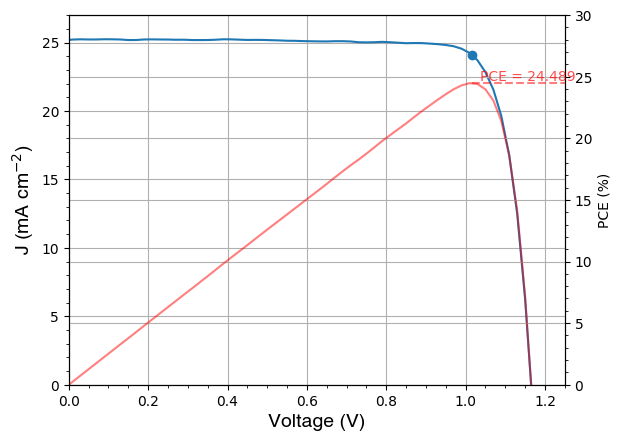

In [2]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(results['v'], results['j'])
ax1.scatter(results['V_mp'],results['J_mp'])
ax1.set_xlabel('Voltage (V)',fontsize=14, family='Helvetica')
ax1.set_ylabel('J (mA cm$^{-2}$)',fontsize=14, family='Helvetica')
ax1.set_ylim(0, 27)
ax1.set_xlim(0, 1.25)
ax1.grid(True)
ax1.minorticks_on()
ax2 = ax1.twinx()
ax2.plot(results['v'], results['v']*results['j'], color='red',alpha=0.5)
ax2.set_ylabel('PCE (%)')
ax2.set_ylim(0, 30)
ax2.set_xlim(0, 1.25)
ax2.plot([results['V_mp'], 1.25], [results['PCE'], results['PCE']], linestyle='--', color='red', alpha=0.5)
ax2.text(results['V_mp'] +.02, results['PCE'] +.5, f'PCE = {results['PCE']:.3f}', ha='left', va='center',color='red',alpha=0.7)
ax2.grid(True)
ax2.minorticks_on()